To verify the legitimacy of observed results we can do what is called a monte carlo simulation, aptly names as it relies on randomness.

We theorise a null hypothesis
> the results are not statistically significant and therefore cannot be used to conclude experiment success

with our alternative

> the results pass the monte test and we can say they are significant 

The format of the following code is as follows;

- As per usual we import all relevant modules and libraries for use in the code
- Check normality (so we know how to design our monte test)
- do the montecarlo test 
- visualise the results and conclude on hypothesis

In [74]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import scipy.stats

We extract a snippet of code from our 'cobbangleanalysis' notebook in which we execute the anderson darling test 

- It will become apparent further down the specific reasoning for this block.

In [75]:
from scipy.stats import anderson

# This block of code is the copied for the cobb angle notebook so see there for detailed anotation but essentialy we compute anderson darling test 
df = pd.read_csv("Table2extract.csv")
df['magnitude_change'] = df.iloc[:,5] - df.iloc[:,6]
mag_clean = np.array(df.iloc[:,13])
mag_clean = mag_clean[~np.isnan(mag_clean)]
result_mag_clean = anderson(mag_clean, dist='norm')
print(result_mag_clean)
def successcheck(statistic, critical_values):
    return "Yes" if statistic <= critical_values[2] else "No"
print(successcheck(result_mag_clean.statistic, result_mag_clean.critical_values))

AndersonResult(statistic=0.21574591756670003, critical_values=array([0.521, 0.593, 0.712, 0.83 , 0.988]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=15.2, scale=15.674270592939553)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Yes


We already know that pre and post op are normally distributed but to avoid error we have checked for the difference in values too as extra reassurance.

Now we know this we can execute the monte carlo simulation, the process is as follows:

- create an new function for use in the test 
- find the 'real' values
- define simulation extent
- now the sim is ran 
- calculate the p values for the hypothesis test 
- print all results

In [76]:
# Check table
df.head()

,ID,Age at Prior Fusion (mo),Age at VEPTR (yr),Age at Last Follow-up CT (yr),Length of Follow-up(yr),Cobb Angle Preoperative,Cobb angle Postoperative,Cobb Angle Last,Thoracic Spine Length (cm) Pre Operative,Thoracic Spine Length (cm) Postoperative,Thoracic Spine Length (cm) Last,Change in Thoracic Spine Length After Initial VEPTR (cm) [last postoperative (cm)],Grovvth/Year Thoracic Spine After Initial Operation (cm) [last — postoperative/ yr (crVyr)],magnitude_change
0,a,NaN,2.1,7.3,5.2,47.0,29.0,29.0,12.3,15.3,20.7,5.4,1.0,18.0
1,b,NaN,9.9,14.7,4.8,30.0,20.0,32.0,NaN,21.1,26.1,5.0,1.0,10.0
2,c,NaN,1.2,5.2,4.0,49.0,47.0,49.0,107.0,12.2,16.0,38.0,1.0,2.0
3,d,NaN,3.4,8.8,5.4,34.0,49.0,49.0,NaN,NaN,21.2,NaN,NaN,-15.0
4,e,NaN,1.0,5.7,4.7,33.0,12.0,16.0,105.0,10.1,13.9,3.8,8.0,21.0


In [77]:

# First to verify that function for the monte carlo workrs we test finding the std and mean of data 
original_data = df.iloc[:,13]
stdtest = original_data.std()
testmean = original_data.mean()

extract = 'magnitude_change'

# create a new custom function that will be the montecarlo sim by defining certain parameters we want 
def monte_carlo_simulation(num_samples, original_data):
    # we generate random numbers that fit the normal distribution 
    # set the mean,standard dev and sample size and dimensions of the new dist. to that of the original data
    simulated_data = np.random.normal(loc=original_data.mean(), scale=original_data.std(), size=(num_samples, len(original_data)))
    # return sends the function result back to the caller (when it is called)
    return simulated_data


# Define the real values from the table 
observed_neg_count = (df[extract] < 0).sum()
observed_pos_count = (df[extract] > 0).sum()

# Number of Monte Carlo simulations
num_simulations = 1000
# the number of simiulations only pertains to the precision of the result and is not derived from anywhere

# Run Monte Carlo simulations using the function we defined above
# create a variable array so that we can store our calculated values
simulated_counts = []
# we want to loop this block for the pre-defined number of sims
for _ in range(num_simulations):
    # init. var from the execute of the monte func 
    # var = monte result
    # len finds row number of df and then we extract the extract df for 
    simulated_data = monte_carlo_simulation(len(df), df[extract]) # we have now an array of sim data points 
    # just like we did for the real data we find the negative and positive values
    simulated_neg_count = (simulated_data < 0).sum()
    simulated_pos_count = (simulated_data > 0).sum()
    # the values found in two lines above are stored into a tuple that and will do so for as many times the block is looped
    simulated_counts.append((simulated_neg_count, simulated_pos_count))

# Calculate p-values - find the probability of observing counts => than the original counts upon random data generation 
p_value_neg = (observed_neg_count <= np.array(simulated_counts)[:, 0]).mean()
p_value_pos = (observed_pos_count <= np.array(simulated_counts)[:, 1]).mean()


# Print results - print ( text : {value} )
print(f"Observed negative count: {observed_neg_count}")
print(f"Observed positive count: {observed_pos_count}")
print("")

# Because we have simulated data in a df we need to extract to print the value
print(f"Mean simulated negative count: {np.mean(np.array(simulated_counts)[:, 0])}")
print(f"Mean simulated positive count: {np.mean(np.array(simulated_counts)[:, 1])}")
print("")

print(f"P-value for negative values: {p_value_neg}")
print(f"P-value for positive values: {p_value_pos}")
print("")

print(f"Test std : {stdtest}")
print(f"mean test : {testmean}")

Observed negative count: 4
Observed positive count: 25

Mean simulated negative count: 159.572
Mean simulated positive count: 801.428

P-value for negative values: 1.0
P-value for positive values: 1.0

Test std : 15.674270592939553
mean test : 15.2


We note that a P value of 1 is improbable and in reality we get closer and closer but do not tend to reach exactly one, this value is here due to software limitation causing a rounding effect. We can observe this very high similarity through the block below

In [78]:
# ratio of negative to pos 
ratio1 = observed_neg_count/observed_pos_count
ratio2 = simulated_neg_count/simulated_pos_count
print(f"prob observed: {ratio1}")
print(f"prob in sim: {ratio2}")

prob observed: 0.16
prob in sim: 0.1937888198757764


These numbers represent the probability of, if one selects a participant by random. The probability it will be a failure observed.

The two probability values are very similar.

The conclusion of this test is that we **Cannot reject the null hypothesis** due to p value being close to 1 and the probabilites are close to identical.

The similarity in distribution can be visualised by plotting the histograms of the observed and simulated data ontop each other

<function matplotlib.pyplot.show(close=None, block=None)>

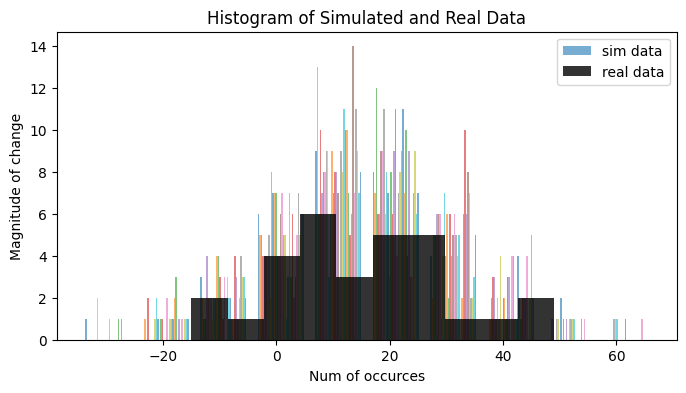

In [79]:
#Define histogram plot size
plot_size = (8,4)

# so that we can plot two hist at once we create a figure defined of subplots 
fig, ax = pp.subplots(figsize=plot_size)

# Plot the simulated and observec data hists and group the data into 10 bins each with a title and transparency value
ax.hist(simulated_data, bins = 10, label = 'sim data', alpha =0.6,)
ax.hist(mag_clean, bins = 10, color='black', label = 'real data', alpha=0.8)

# Add in plot info - title and labels
ax.set_xlabel('Num of occurces')
ax.set_ylabel('Magnitude of change')
ax.set_title('Histogram of Simulated and Real Data')

# Legend for discrim
ax.legend()
# Print stored graphs
pp.show